In [67]:
import numpy as np
import pandas as pd
import shap
import optuna
from xgboost import XGBRegressor 
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [68]:
df = pd.read_csv('data/engineered_grit_data.csv')
df.head()

,surveyelapse,VCL1,VCL2,VCL3,VCL4,VCL5,VCL7,VCL8,VCL10,VCL11,...,operatingsystem_ChromeOS,operatingsystem_Linux,operatingsystem_Macintosh,operatingsystem_Unknown,operatingsystem_Windows,operatingsystem_Windows Phone,operatingsystem_iOS,age_group_18-30,age_group_30-45,age_group_45+
0,340,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,126,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,1,0
2,130,1,1,1,1,1,0,1,1,1,...,0,0,0,0,1,0,0,0,0,1
3,592,1,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,217,1,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


In [69]:
X = df[['C8', 'C9', 'C1', 'C10', 'C5', 'C4', 'N7', 'C3', 'A10', 'C2', 'N5', 'A8', 'O2', 'E10', 'age_group_18-30']]
y = df['Grit']

X.shape

(2200, 15)

MAE_train: 0.06167246981552153
MAE_test: 0.4140040729985093
RMSE_train: 0.09356388311700392
RMSE_test: 0.5373225799826234
R2_train: 0.9821168058182422
R2_test: 0.39111650541656384
[0.14907159 0.0590253  0.08873548 0.05797023 0.0580899  0.15184915
 0.06245806 0.05190331 0.05107511 0.03733103 0.05649153 0.03984112
 0.04151087 0.03907773 0.05556965]


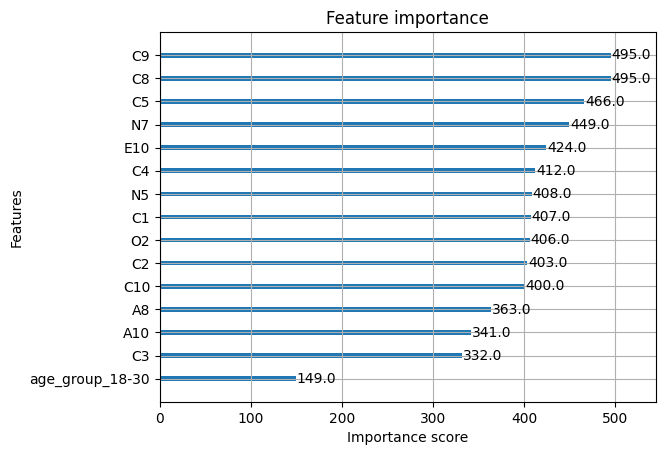

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBRegressor(
    random_state=42
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
MAE_test  = mean_absolute_error(y_test, y_pred_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
RMSE_test  = np.sqrt(mean_squared_error(y_test, y_pred_test))

R2_train = r2_score(y_train, y_pred_train)
R2_test  = r2_score(y_test, y_pred_test)

print("MAE_train:", MAE_train)
print("MAE_test:", MAE_test)

print("RMSE_train:", RMSE_train)
print("RMSE_test:", RMSE_test)

print("R2_train:", R2_train)
print("R2_test:", R2_test)

print(model.feature_importances_)

plot_importance(model, max_num_features=20)
plt.show()

In [58]:
param_grid = {
    'n_estimators': [200, 400, 600, 800],
    'learning_rate': [0.005, 0.01, 0.03],
    'max_depth': [3, 4, 5, 6, 8],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.1, 1]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=100,                  
    cv=5,                      
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1               
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", -random_search.best_score_)

best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
MAE_test  = mean_absolute_error(y_test, y_pred_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
RMSE_test  = np.sqrt(mean_squared_error(y_test, y_pred_test))

R2_train = r2_score(y_train, y_pred_train)
R2_test  = r2_score(y_test, y_pred_test)

print("MAE_train:", MAE_train)
print("MAE_test:", MAE_test)

print("RMSE_train:", RMSE_train)
print("RMSE_test:", RMSE_test)

print("R2_train:", R2_train)
print("R2_test:", R2_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'reg_lambda': 0.01, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.6}
Best CV score: 0.2490147516156782
MAE_train: 0.36387062908122036
MAE_test: 0.38694286003257294
RMSE_train: 0.4522478537097572
RMSE_test: 0.48647287743917655
R2_train: 0.5821872914462637
R2_test: 0.5009072255719287


In [71]:
param_grid = {
    'n_estimators': [150, 200, 300],
    'learning_rate': [0.02, 0.03, 0.04],
    'max_depth': [2, 3, 4],
    'min_child_weight': [3, 5, 7],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.5, 0.6],
    'gamma': [0.2, 0.3, 0.4],
    'reg_alpha': [0.5, 1],
    'reg_lambda': [0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", -grid_search.best_score_)

best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
MAE_test  = mean_absolute_error(y_test, y_pred_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
RMSE_test  = np.sqrt(mean_squared_error(y_test, y_pred_test))

R2_train = r2_score(y_train, y_pred_train)
R2_test  = r2_score(y_test, y_pred_test)

print("MAE_train:", MAE_train)
print("MAE_test:", MAE_test)

print("RMSE_train:", RMSE_train)
print("RMSE_test:", RMSE_test)

print("R2_train:", R2_train)
print("R2_test:", R2_test)

Fitting 3 folds for each of 5832 candidates, totalling 17496 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.4, 'learning_rate': 0.04, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 150, 'reg_alpha': 1, 'reg_lambda': 0.001, 'subsample': 0.7}
Best CV score: 0.248766605891486
MAE_train: 0.36387062908122036
MAE_test: 0.38694286003257294
RMSE_train: 0.4522478537097572
RMSE_test: 0.48647287743917655
R2_train: 0.5821872914462637
R2_test: 0.5009072255719287


In [59]:
X = df[['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'N1', 'N2',
       'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'A1', 'A2', 'A3', 'A4',
       'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8',
       'O9', 'O10', 'age_group_18-30', 'age_group_30-45',
       'age_group_45+', 'vocab_score', 'married_Currently married',
       'married_Never married', 'married_Previously married']]

MAE_train: 0.013331879314148073
MAE_test: 0.41798254079890984
RMSE_train: 0.02103482045706571
RMSE_test: 0.5319728132119403
R2_train: 0.9990961294514312
R2_test: 0.4031806508335716
[0.00436096 0.00824266 0.01015907 0.00703395 0.00910512 0.00868299
 0.0135073  0.00799392 0.00615361 0.00950371 0.00739873 0.00961325
 0.0069754  0.00794654 0.01875162 0.00988586 0.01849874 0.01323299
 0.01286502 0.01632914 0.01029553 0.0108636  0.00593393 0.01297383
 0.01283885 0.0076718  0.01533436 0.00702666 0.01059461 0.01224066
 0.06248181 0.01001864 0.02157359 0.13220388 0.03240119 0.02311956
 0.00966861 0.13107471 0.04255216 0.03653459 0.00479469 0.01552537
 0.00642576 0.00567348 0.01132899 0.00862375 0.01416071 0.00782295
 0.00826116 0.00674499 0.01986288 0.01039538 0.01579642 0.00923994
 0.00888893 0.01710905 0.01570233]


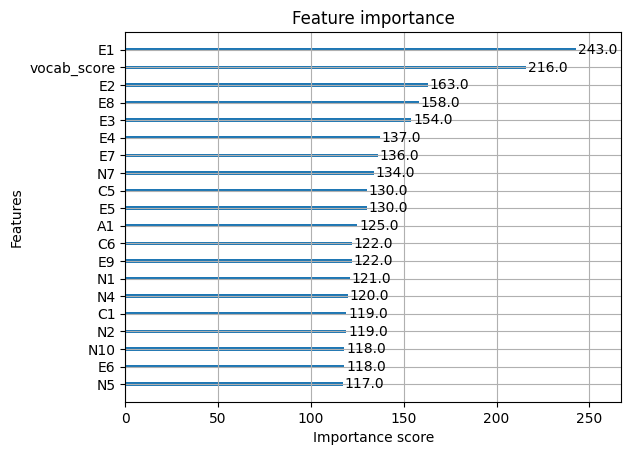

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBRegressor(
    random_state=42
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
MAE_test  = mean_absolute_error(y_test, y_pred_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
RMSE_test  = np.sqrt(mean_squared_error(y_test, y_pred_test))

R2_train = r2_score(y_train, y_pred_train)
R2_test  = r2_score(y_test, y_pred_test)

print("MAE_train:", MAE_train)
print("MAE_test:", MAE_test)

print("RMSE_train:", RMSE_train)
print("RMSE_test:", RMSE_test)

print("R2_train:", R2_train)
print("R2_test:", R2_test)

print(model.feature_importances_)

plot_importance(model, max_num_features=20)
plt.show()

In [61]:
params = model.get_params()
print(params)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
